In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# abbreviation for plotting functions in certain range
def plot(f, xRange, *args, **kw):
    yRange = np.fromiter(map(f,xRange), np.float)
    plt.plot(xRange,yRange, *args, **kw)

## Generate data - bimolecular reaction
System is $A+B\rightarrow C$ with CME rate $\kappa$. 
Defining a volume $V$, the corresponding LMA rate is $\xi = V\kappa$

In [2]:
import generate_tools.kinetic_monte_carlo as kmc

In [3]:
n_species = 3
n_boxes = 1
rate = 2.
diffusivity_a = np.array([[0.]])
diffusivity_b = np.array([[0.]])
diffusivity_c = np.array([[0.]])
diffusivity = np.array([diffusivity_a, diffusivity_b, diffusivity_c])
init_state = np.array([[50, 50, 0]])
species_names = ["A", "B", "C"]
system = kmc.ReactionDiffusionSystem(diffusivity, 3, 1, init_state, species_names=species_names)
system.add_fusion("A", "B", "C", np.array([rate]))
system.simulate(1000)
counts, times = system.convert_events_to_time_series(n_frames=10000)
# flatten out spatial dimension and convert to float
counts = np.sum(counts, axis=1, dtype=np.float64)
config = system.get_trajectory_config()

[KMC] [2017-06-29 18:39:48] [INFO] Simulate for 1000 steps
[KMC] [2017-06-29 18:39:48] [INFO] No events possible / system is frustrated, at step 50


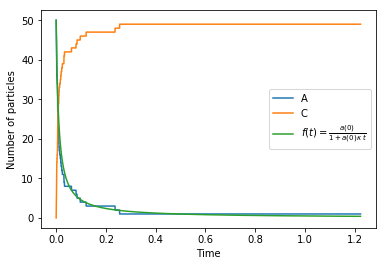

In [4]:
plt.plot(times, counts[:, config.types["A"]], label="A")
#plt.plot(times, counts[:, config.types["B"]], label="B")
plt.plot(times, counts[:, config.types["C"]], label="C")
plot(lambda x: init_state[0,0] / (1. + (init_state[0,0] * rate * x)), 
     times, label=r"$f(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Number of particles")

## Reverse-engineer

### Load data into Trajectory object

In [5]:
import py_analyze_tools.tools as pat

In [6]:
traj = pat.Trajectory.from_counts(config, counts, times[1]-times[0])
traj.update()

max counts = 50.0, min nonzero counts = 1.0


In [7]:
traj.counts

array([[ 50.,  50.,   0.],
       [ 49.,  49.,   1.],
       [ 48.,  48.,   2.],
       ..., 
       [  1.,   1.,  49.],
       [  1.,   1.,  49.],
       [  1.,   1.,  49.]])

### Define ansatz reactions via the BasisFunctionConfiguration object

In [8]:
from py_analyze_tools.sklearn import BasisFunctionConfiguration

In [9]:
bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_fusion(0, 1, 2) # A + B -> C
#bfc.add_fission(2, 0, 1) # C -> A + B
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(2, 0) # C -> A
right_rates = np.array([rate, 0., 0., 0.])

In [10]:
bfc.n_basis_functions

1

### Estimate model parameters using least-squares

In [11]:
from py_analyze_tools.sklearn import ReaDDyElasticNetEstimator

In [15]:
scale = 1.
est = ReaDDyElasticNetEstimator(traj, bfc, scale, 
                                alpha=0., l1_ratio=0.,
                                verbose=True, approx_jac=False, options={'ftol': 1e-12})
est.fit(None)
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)
print("right rates =%s" % right_rates)

optimization problem did exit successfully (alpha=0.0, lambda=0.0)!
status 0: Optimization terminated successfully.
2 / 15000 iterations
coefficients=[ 2.57104795]
right rates =[ 2.  0.  0.  0.]


### Results

In [16]:
from scipy.integrate import odeint

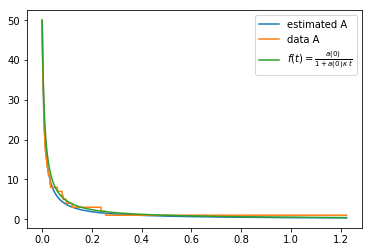

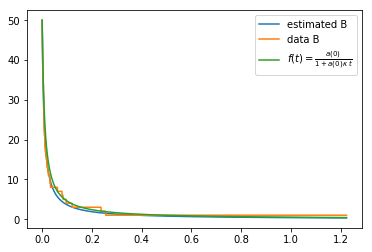

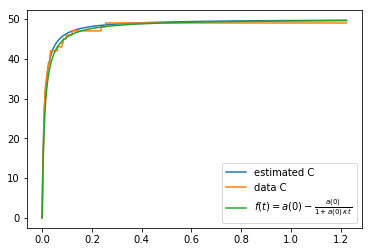

In [17]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(coefficients, theta)

estimated_realisation = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*traj.time_step, traj.time_step))
for t in ["A", "B", "C"]:
    type_id = config.types[t]
    plt.plot(times, estimated_realisation[:, type_id], label="estimated "+t)
    plt.plot(times, traj.counts[:, type_id], label="data "+t)
    actual_model = lambda x: traj.counts[0,0] / (1. + (traj.counts[0,0] * rate * x))
    if t=="A" or t=="B":
        plot(actual_model, times, label=r"$f(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    else:
        plot(lambda x: traj.counts[0,0] - actual_model(x),
             times, label=r"$f(t) =a(0) - \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    plt.legend(loc="best")
    plt.show()